#  Attributes for both student-mat.csv (Math course) datasets:

1. school - student's school (binary: "GP" - Gabriel Pereira or "MS" - Mousinho da Silveira)

2. gender - student's sex (binary: "F" - female or "M" - male)

3. age - student's age (numeric: from 15 to 22)

4. address - student's home address type (binary: "U" - urban or "R" - rural)

5. famsize - family size (binary: "LE3" - less or equal to 3 or "GT3" - greater than 3)

6. Pstatus - parent's cohabitation status (binary: "T" - living together or "A" - apart)

7. Medu - mother's education (numeric: 0 - none, 1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)

8. Fedu - father's education (numeric: 0 - none, 1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)

9. Mjob - mother's job (nominal: "teacher", "health" care related, civil "services" (e.g. administrative or police), "at_home" or "other")

10. Fjob - father's job (nominal: "teacher", "health" care related, civil "services" (e.g. administrative or police), "at_home" or "other")

11. reason - reason to choose this school (nominal: close to "home", school "reputation", "course" preference or "other")

12. guardian - student's guardian (nominal: "mother", "father" or "other")

13. traveltime - home to school travel time (numeric: 1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour)

14. studytime - weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)

15. failures - number of past class failures (numeric: n if 1<=n<3, else 4)

16. schoolsup - extra educational support (binary: yes or no)

17. famsup - family educational support (binary: yes or no)

18. paid - extra paid classes within the course subject (Math or Portuguese) (binary: yes or no)

19. activities - extra-curricular activities (binary: yes or no)

20. nursery - attended nursery school (binary: yes or no)

21. higher - wants to take higher education (binary: yes or no)

22. internet - Internet access at home (binary: yes or no)

23. romantic - with a romantic relationship (binary: yes or no)

24. famrel - quality of family relationships (numeric: from 1 - very bad to 5 - excellent)

25. freetime - free time after school (numeric: from 1 - very low to 5 - very high)

26. goout - going out with friends (numeric: from 1 - very low to 5 - very high)

27. Dalc - workday alcohol consumption (numeric: from 1 - very low to 5 - very high)

28. Walc - weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)

29. health - current health status (numeric: from 1 - very bad to 5 - very good)

30. absences - number of school absences (numeric: from 0 to 93)

31. G1 - first period grade (numeric: from 0 to 20)

31. G2 - second period grade (numeric: from 0 to 20)

32. G3 - final grade (numeric: from 0 to 20, output target)


In [1]:
import math
import scipy
import random
import joblib
import squarify
import numpy as np
import pandas as pd
import seaborn as sns
import dill as pickle
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.pipeline import Pipeline
from scipy.stats import shapiro, spearmanr
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from tensorflow.keras.layers import Dense, LeakyReLU
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, OneHotEncoder

2024-11-11 11:58:32.025779: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


# Data Wrangling

## Gathering Data

In [2]:
# Set display options to show all columns
pd.set_option('display.max_columns', None)
data = pd.read_csv('./data/student-por.csv', delimiter=';')
data = pd.DataFrame(data)
data.rename(columns={'sex': 'gender'}, inplace=True)
obj_columns = data.select_dtypes(include=['object']).columns
int_columns = data.select_dtypes(include=['int64']).columns

## Assessing Data

### Information Of Data

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   gender      649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

### Describe Data

#### Grouping
|No|Description  |Column Name|Count|PreProcess|
|--|--|--|--|--|
| 1 |2 Values`[label]`  |school, gender, address, famsize, Pstatus|5|OneHotEncoder|
| 2 |2 Values`[binary]`  |schoolsup, famsup, paid, activities, nursery, higher, internet, romantic|8|OneHotEncoder|
|3| Numeric`<=5`|Medu, Fedu, traveltime, studytime, failures, famrel, freetime, gout, Dalc, Walc, health|11|'passthrough'|
|4| Numeric`>5`|age, absences, G1, G2, G3|5|MinMaxScaler|
|5| Int`>2 Choices`|Mjob, Fjob, reason, guardian|4|OneHotEncoder|

### Normalize Data

In [17]:
data_X = data.drop(columns='school')
data_y = data['school']
data_y = pd.DataFrame(data_y, columns=['school'])

In [18]:
pipeline = joblib.load('./function/pipeline.pkl')

with open('./function/transform_function.pkl', 'rb') as file:
    transform_and_sort, desired_prefix_order = pickle.load(file)
    data_transformed_sorted = transform_and_sort(data_X, pipeline, desired_prefix_order)

In [19]:
pipeline_y = joblib.load('./function/pipeline_y.pkl')

with open('./function/transform_function_y.pkl', 'rb') as file:
    transform_and_sort_y, desired_prefix_order_y = pickle.load(file)
    data_transformed_sorted_y = transform_and_sort_y(data_y, pipeline_y, desired_prefix_order_y)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(data_transformed_sorted, data_transformed_sorted_y, test_size=0.2, random_state=15, stratify=data_transformed_sorted_y)

In [21]:
X_train_corr = X_train[["Medu","Fedu","traveltime","health","studytime"]]
X_test_corr = X_test[["Medu","Fedu","traveltime","health","studytime"]]
X_train_uncorr = X_train.drop(["Medu","Fedu","traveltime","health","studytime"], axis=1)
X_test_uncorr = X_test.drop(["Medu","Fedu","traveltime","health","studytime"], axis=1)
X_train_noncorr = X_train.drop(["famrel","freetime","Dalc","Walc","goout"], axis=1)
X_test_noncorr = X_test.drop(["famrel","freetime","Dalc","Walc","goout"], axis=1)

In [22]:
scaler = joblib.load('./function/scaler.pkl')
data_transformed_scaled = scaler.transform(data_transformed_sorted)
scaler_corr = StandardScaler()
X_train_corr_scaled = scaler_corr.fit_transform(X_train_corr)
X_test_corr_scaled = scaler_corr.transform(X_test_corr)
scaler_uncorr = StandardScaler()
X_train_uncorr_scaled = scaler_uncorr.fit_transform(X_train_uncorr)
X_test_uncorr_scaled = scaler_uncorr.transform(X_test_uncorr)
scaler = StandardScaler()
X_train_noncorr_scaled = scaler.fit_transform(X_train_noncorr)
X_test_noncorr_scaled = scaler.transform(X_test_noncorr)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(data_transformed_scaled, data_transformed_sorted_y, test_size=0.2, random_state=15, stratify=data_transformed_sorted_y)

# EDA

In [11]:
data.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000
mean,16.744222,2.514638,2.306626,1.568567,1.930663,0.221880,3.930663,3.180277,3.184900,1.502311,2.280431,3.536210,3.659476,11.399076,11.570108,11.906009
std,1.218138,1.134552,1.099931,0.748660,0.829510,0.593235,0.955717,1.051093,1.175766,0.924834,1.284380,1.446259,4.640759,2.745265,2.913639,3.230656
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,2.000000,0.000000,10.000000,10.000000,10.000000
50%,17.000000,2.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,11.000000,12.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,32.000000,19.000000,19.000000,19.000000


In [12]:
int_columns_filtered = int_columns.drop('absences')

int_columns_filtered1 = int_columns.drop(['absences', 'G1', 'G2', 'G3', 'age'])

int_columns_filtered2 = ['age']

two_value_columns = [column for column in obj_columns if data[column].nunique() == 2]

nottwo_value_columns = [column for column in obj_columns if data[column].nunique() > 2]


In [13]:
# Filter columns with exactly two unique values

# Function to plot combined treemaps for columns with exactly two unique values
def plot_combined_pie_charts(columns, name=""):
    n_cols = 4
    n_rows = (len(columns) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
    axes = axes.flatten()

    for i, column in enumerate(columns):
        value_counts = data[column].value_counts()
        labels = value_counts.index
        sizes = value_counts.values
        colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]
        
        axes[i].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, textprops={'size': 20})  # Increased text size to 14 # Increased text size
        axes[i].set_title(f'{column}', fontdict={'fontsize': 24, 'fontweight': 'bold'}, pad=20)  # Added margin bottom to the title
        axes[i].set_ylabel('')  # Hiding the Y label
        axes[i].set_xlabel('')  # Hiding the X label
        axes[i].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    fig.suptitle(f'{name}', fontsize=24, fontweight='bold')  # Adding a grand title

    # Remove any unused subplots
    for i in range(len(columns), len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout(pad=2.0)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

In [14]:
# Filter columns with exactly two unique values

# Function to plot combined treemaps for columns with exactly two unique values
def plot_combined_treemap_not2(columns, name=""):
    n_cols = 2
    n_rows = (len(columns) + 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))
    axes = axes.flatten()

    for i, column in enumerate(columns):
        value_counts = data[column].value_counts()
        labels = [f'{i}\n{v}' for i, v in zip(value_counts.index, value_counts.values)]
        sizes = value_counts.values
        colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]
        
        squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8, ax=axes[i], text_kwargs={'fontsize': 16})
        axes[i].set_title(f'{column}', fontsize=20)
        axes[i].axis('off')

    fig.suptitle(f'{name}', fontsize=20, fontweight='bold') 

    # Remove any unused subplots
    for i in range(len(columns), len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout(pad=2.0)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

In [15]:
def plot_distribution(data, int_columns_filtered1, name=""):
    fig, ax = plt.subplots(figsize=(16, 10), dpi=200)
    ax.hlines(y=range(len(int_columns_filtered1)), xmin=-1, xmax=6, color='gray', alpha=0.5, linewidth=.5, linestyles='dashdot')

    for i, column in enumerate(int_columns_filtered1):
        ax.scatter(y=np.repeat(i, data.shape[0]), x=data[column], s=75, edgecolors='gray', c='w', alpha=0.5)
        ax.scatter(y=i, x=data[column].median(), s=75, c='firebrick')  

    ax.text(5, len(data.columns) - 1, "", fontdict={'size': 25}, color='firebrick')

    red_patch = plt.plot([], [], marker="o", ms=10, ls="", mec=None, color='firebrick', label="Median")
    plt.legend(handles=red_patch, fontsize=16, loc='lower right')
    ax.set_title(f'{name}', fontdict={'size': 22})
    ax.set_xlabel('Values', alpha=0.7, fontsize=18)
    ax.set_yticks(range(len(int_columns_filtered1)))
    ax.set_yticklabels(int_columns_filtered1, fontdict={'horizontalalignment': 'right'}, alpha=0.7, fontsize=18)
    ax.set_xlim(-1, 6)

    xticks = np.arange(-1, 7)
    xtick_labels = [str(x) if x not in [-1, 6] else '' for x in xticks]
    plt.xticks(ticks=xticks, labels=xtick_labels, alpha=0.7)

    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["bottom"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["left"].set_visible(False)
    plt.grid(axis='both', alpha=.4, linewidth=.1)


In [16]:
def plot_boxplot(data, int_columns_filtered2, name=""):
    # Determine the number of columns to adjust the figsize
    num_columns = len(int_columns_filtered2)
    figsize_x = max(3, num_columns * 0.5)  # Adjust width based on number of columns
    figsize_y = max(5, num_columns * 0.5)  # Keep height constant or adjust based on data as needed
    
    plt.figure(figsize=(figsize_x, figsize_y))
    sns.boxplot(data=data[int_columns_filtered2], showmeans=True, meanline=True,
                meanprops={'color': 'k', 'ls': '--', 'lw': 1},
                medianprops={'color': 'k', 'lw': 1})
    plt.xticks(fontsize=18)
    max_y = int(data[int_columns_filtered2].max().max())
    min_y = int(data[int_columns_filtered2].min().min()) - 2
    plt.yticks(range(min_y, max_y + 2, 1), fontsize=18)

    # Create legend elements
    legend_elements = [Line2D([], [], color='k', linestyle='--', lw=1, label='Mean'),
                       Line2D([], [], color='k', linestyle='-', label='Median'),
                       Line2D([], [], color='k', marker='o', fillstyle='none', label='Outlier', linewidth=0)]

    # Add legend outside the plot
    plt.legend(handles=legend_elements, fontsize=18, loc='upper left', bbox_to_anchor=(1, 1))

    # Decoration
    plt.title(f'{name}', fontsize=22)
    plt.show()

In [17]:
def plot_normality_tests(data, int_columns_filtered2, name="", alpha=0.05):
    # Filter the data for the specified columns
    df = data[int_columns_filtered2]
    num_columns = len(df.columns)

    # Determine the number of rows and columns needed for the subplots
    num_rows = math.ceil(num_columns / 3)
    
    # Create the subplots
    f, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))
    plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.4, hspace=0.5)
    
    # Flatten axes array to simplify indexing
    axes = axes.flatten()
    
    for j, column in enumerate(df.columns):
        # Histogram 
        hist_plot = sns.histplot(df[column], ax=axes[j], kde=True, color='blue')
        hist_plot.set_xlabel(column, fontsize=18)
        hist_plot.set_ylabel("Count", fontsize=18)
        statistic, p_value = shapiro(df[column].dropna())  # Drop NA values before applying Shapiro-Wilk test
        axes[j].tick_params(axis='x', labelsize=16)
        axes[j].tick_params(axis='y', labelsize=16)
        if p_value > alpha:
            hist_plot.set_title(f'p-value: {p_value:.4f} \nData Distribution Normal', fontsize=18)
        else:
            hist_plot.set_title(f'p-value: {p_value:.4f} \nData Distribution Not Normal', fontsize=18)
    
    # Hide any unused subplots
    for k in range(j + 1, len(axes)):
        axes[k].axis('off')
    
    plt.suptitle(f'{name}\n(alpha = {alpha:.2f})', fontsize=20, y=1.02)
    plt.show()

In [18]:
def heatmaps_spearman(data, column_labels, name=""):
    # Create subplots
    f, axes = plt.subplots(1, 2, figsize=(38, 20), gridspec_kw={'width_ratios': [1, 0.05]})
    
    # Spearman correlation
    correlation_spearman = data.corr(method='spearman')
    spearman_heatmap = sns.heatmap(
        correlation_spearman, 
        cmap='coolwarm', 
        annot=True, 
        fmt='.3f', 
        annot_kws={"size": 40},  # Adjust the size of the annotations
        ax=axes[0], 
        vmin=-1, 
        vmax=1, 
        cbar=True, 
        cbar_ax=axes[1]
    )
    # Adjust colorbar font size
    colorbar = spearman_heatmap.collections[0].colorbar
    colorbar.ax.tick_params(labelsize=20)
    #// spearman_heatmap.set_title("Spearman Correlation", fontsize=30)
    spearman_heatmap.set_xticklabels(column_labels, rotation=45, ha='right', fontsize=25)
    spearman_heatmap.set_yticklabels(column_labels, rotation=0, fontsize=30)
    
    # Set overall title
    plt.suptitle(f"{name}", fontsize=45)
    
    return correlation_spearman;

# Get the top N correlations
def get_top_correlations_with_column(correlation_matrix, target_column, top_n=10):
    """
    Extracts the top N correlations involving the target_column.

    Parameters:
    - correlation_matrix (pd.DataFrame): The correlation matrix.
    - target_column (str): The column for which top correlations are to be found.
    - top_n (int): Number of top correlations to retrieve.

    Returns:
    - pd.Series: A series containing the top N correlations with the target_column.
    """
    # Check if the target_column exists in the correlation_matrix
    if target_column not in correlation_matrix.columns:
        raise ValueError(f"Column '{target_column}' not found in the correlation matrix.")

    # Extract correlations for the target column and drop self-correlation
    target_correlations = correlation_matrix[target_column].drop(labels=[target_column])

    # Sort correlations by absolute value in descending order
    sorted_correlations = target_correlations.abs().sort_values(ascending=False)

    # Select the top N correlations
    top_correlations = sorted_correlations.head(top_n).index

    # Retrieve the actual correlation values (including sign)
    top_correlations_values = correlation_matrix.loc[top_correlations, target_column]

    return top_correlations_values

# Plot the top correlations
def plot_correlations_with_column(correlations, target_column, title, figsize=(10, 8)):
    """
    Plots a horizontal bar chart of correlations with a target column.

    Parameters:
    - correlations (pd.Series): Series containing correlation values with variable names as index.
    - target_column (str): The target column name.
    - title (str): Title of the plot.
    - figsize (tuple): Size of the plot.
    """
    plt.figure(figsize=figsize)
    sns.barplot(x=correlations.values, y=correlations.index, palette='coolwarm')

    # Annotate each bar with the correlation value
    for index, value in enumerate(correlations.values):
        plt.text(value, index, f'{value:.2f}', va='center', ha='left' if value < 0 else 'right', 
                 fontsize=12, color='black')

    plt.title(title, fontsize=20)
    plt.xlabel('Spearman Correlation', fontsize=15)
    plt.ylabel(f'Variables Correlated with {target_column}', fontsize=15)
    plt.xlim(-1, 1)  # Since Spearman correlation ranges from -1 to 1
    plt.tight_layout()
    plt.show() 



In [19]:
with open('all_functions.pkl', 'wb') as file:
    pickle.dump((plot_combined_pie_charts, plot_combined_treemap_not2, plot_distribution, plot_boxplot, plot_normality_tests, heatmaps_spearman, get_top_correlations_with_column, plot_correlations_with_column),file)

with open('all_functions.pkl', 'rb') as file:
    plot_combined_pie_charts, plot_combined_treemap_not2, plot_distribution, plot_boxplot, plot_normality_tests, heatmaps_spearman, get_top_correlations_with_column, plot_correlations_with_column = pickle.load(file)

# Data Visualization

## Pie Chart

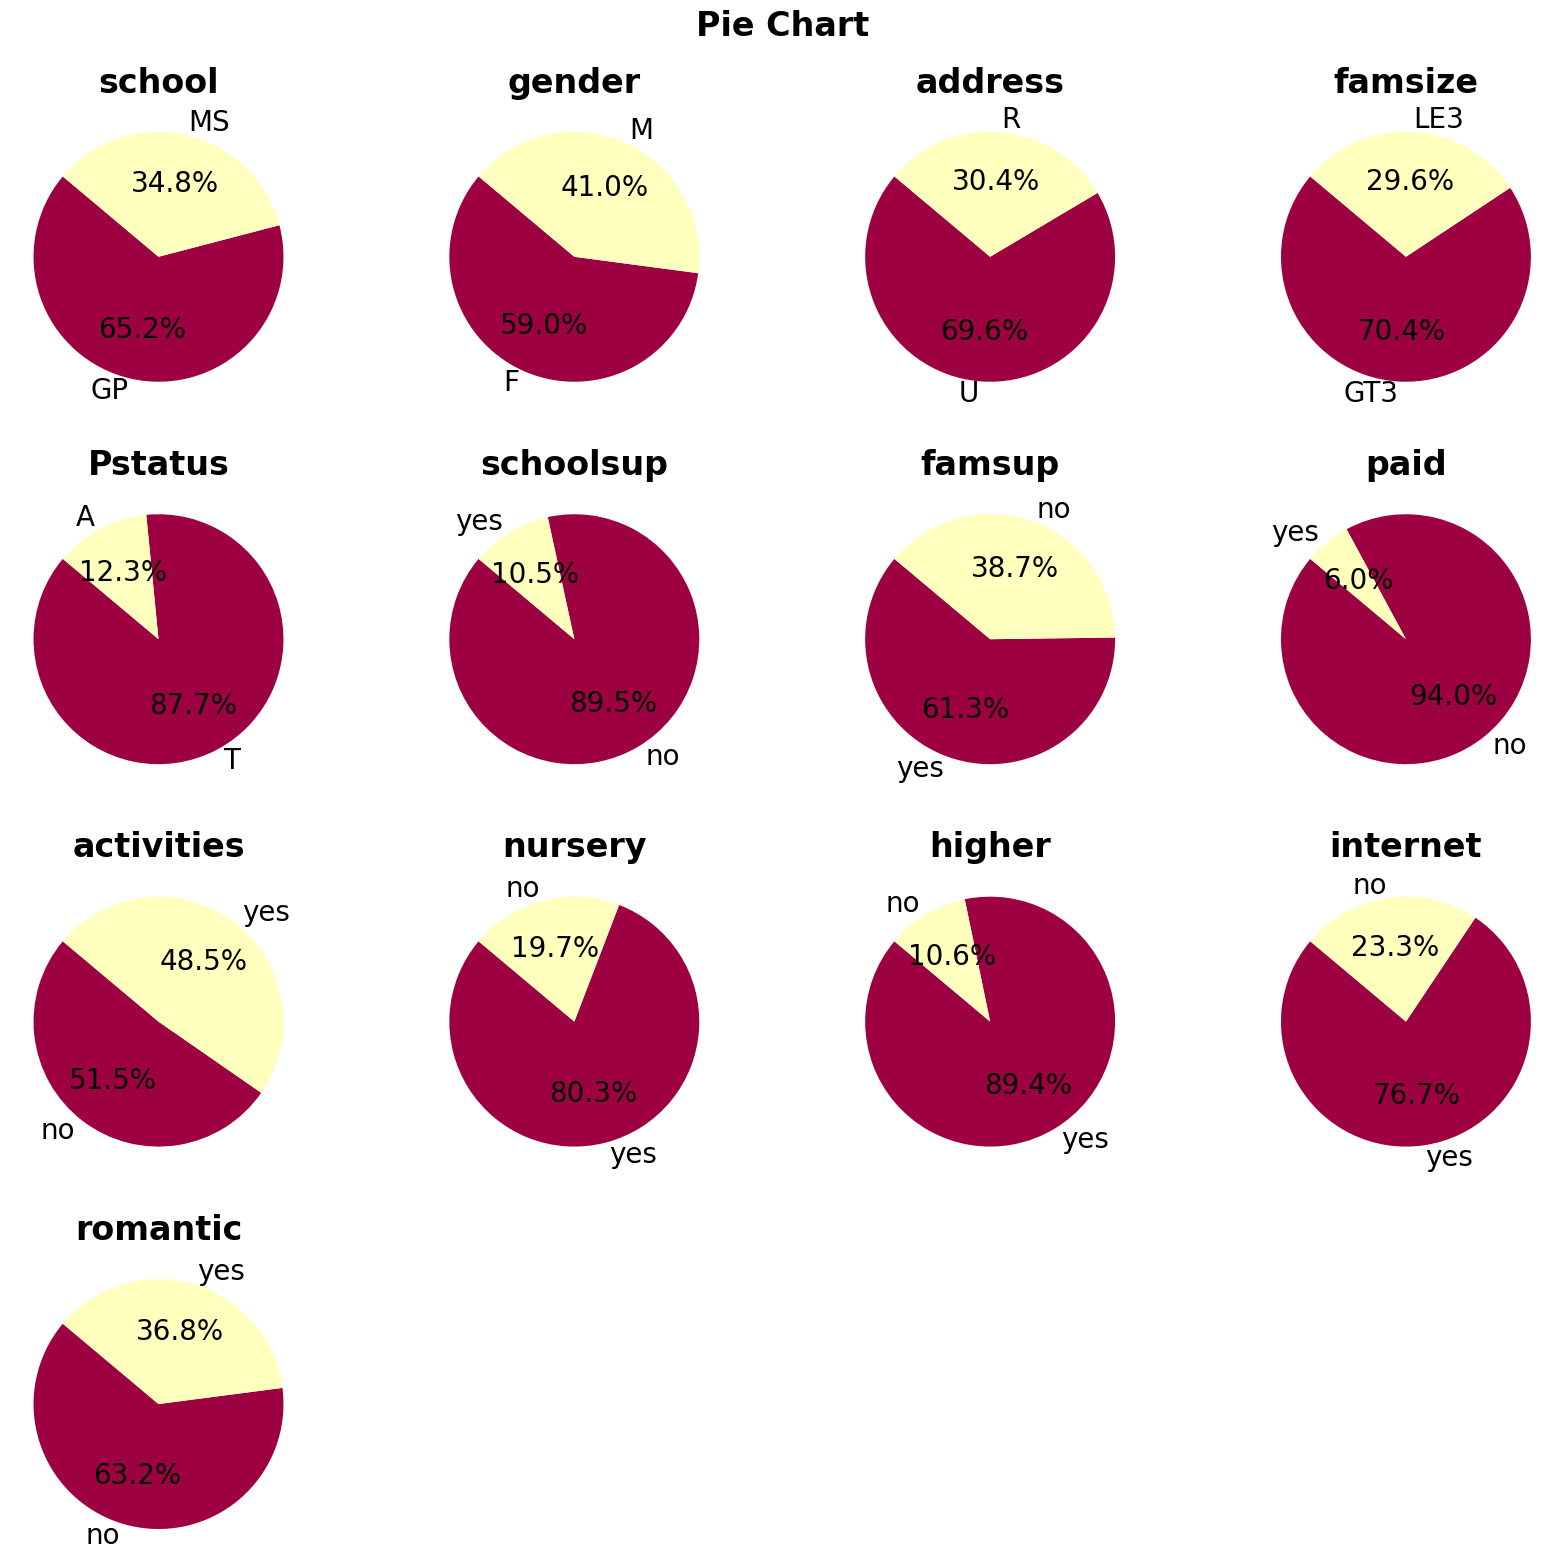

In [20]:
# Plot treemaps for columns with exactly two unique values
plot_combined_pie_charts(two_value_columns, 'Pie Chart')
plt.show()

## Treemap

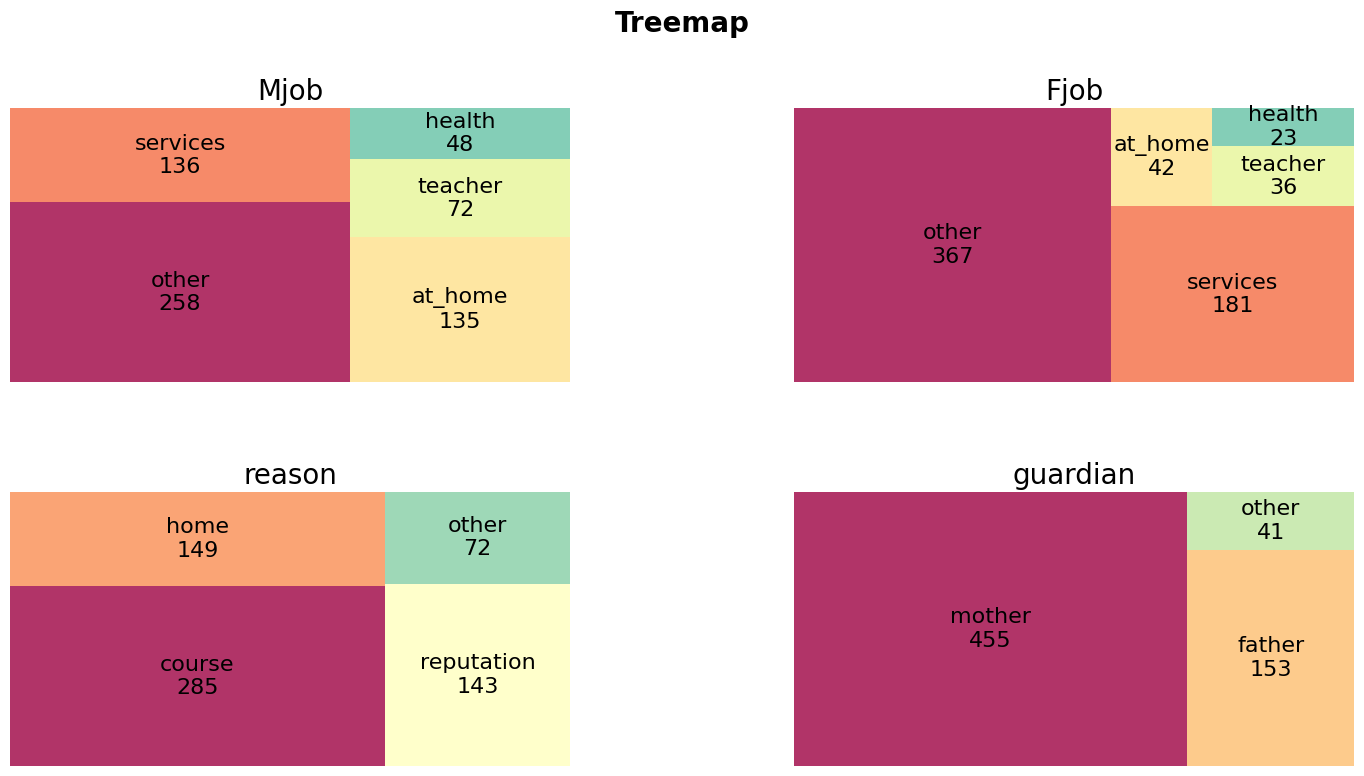

In [21]:
# Plot treemaps for columns with exactly two unique values
plot_combined_treemap_not2(nottwo_value_columns, 'Treemap')
plt.show()

## Distributed Data Plot

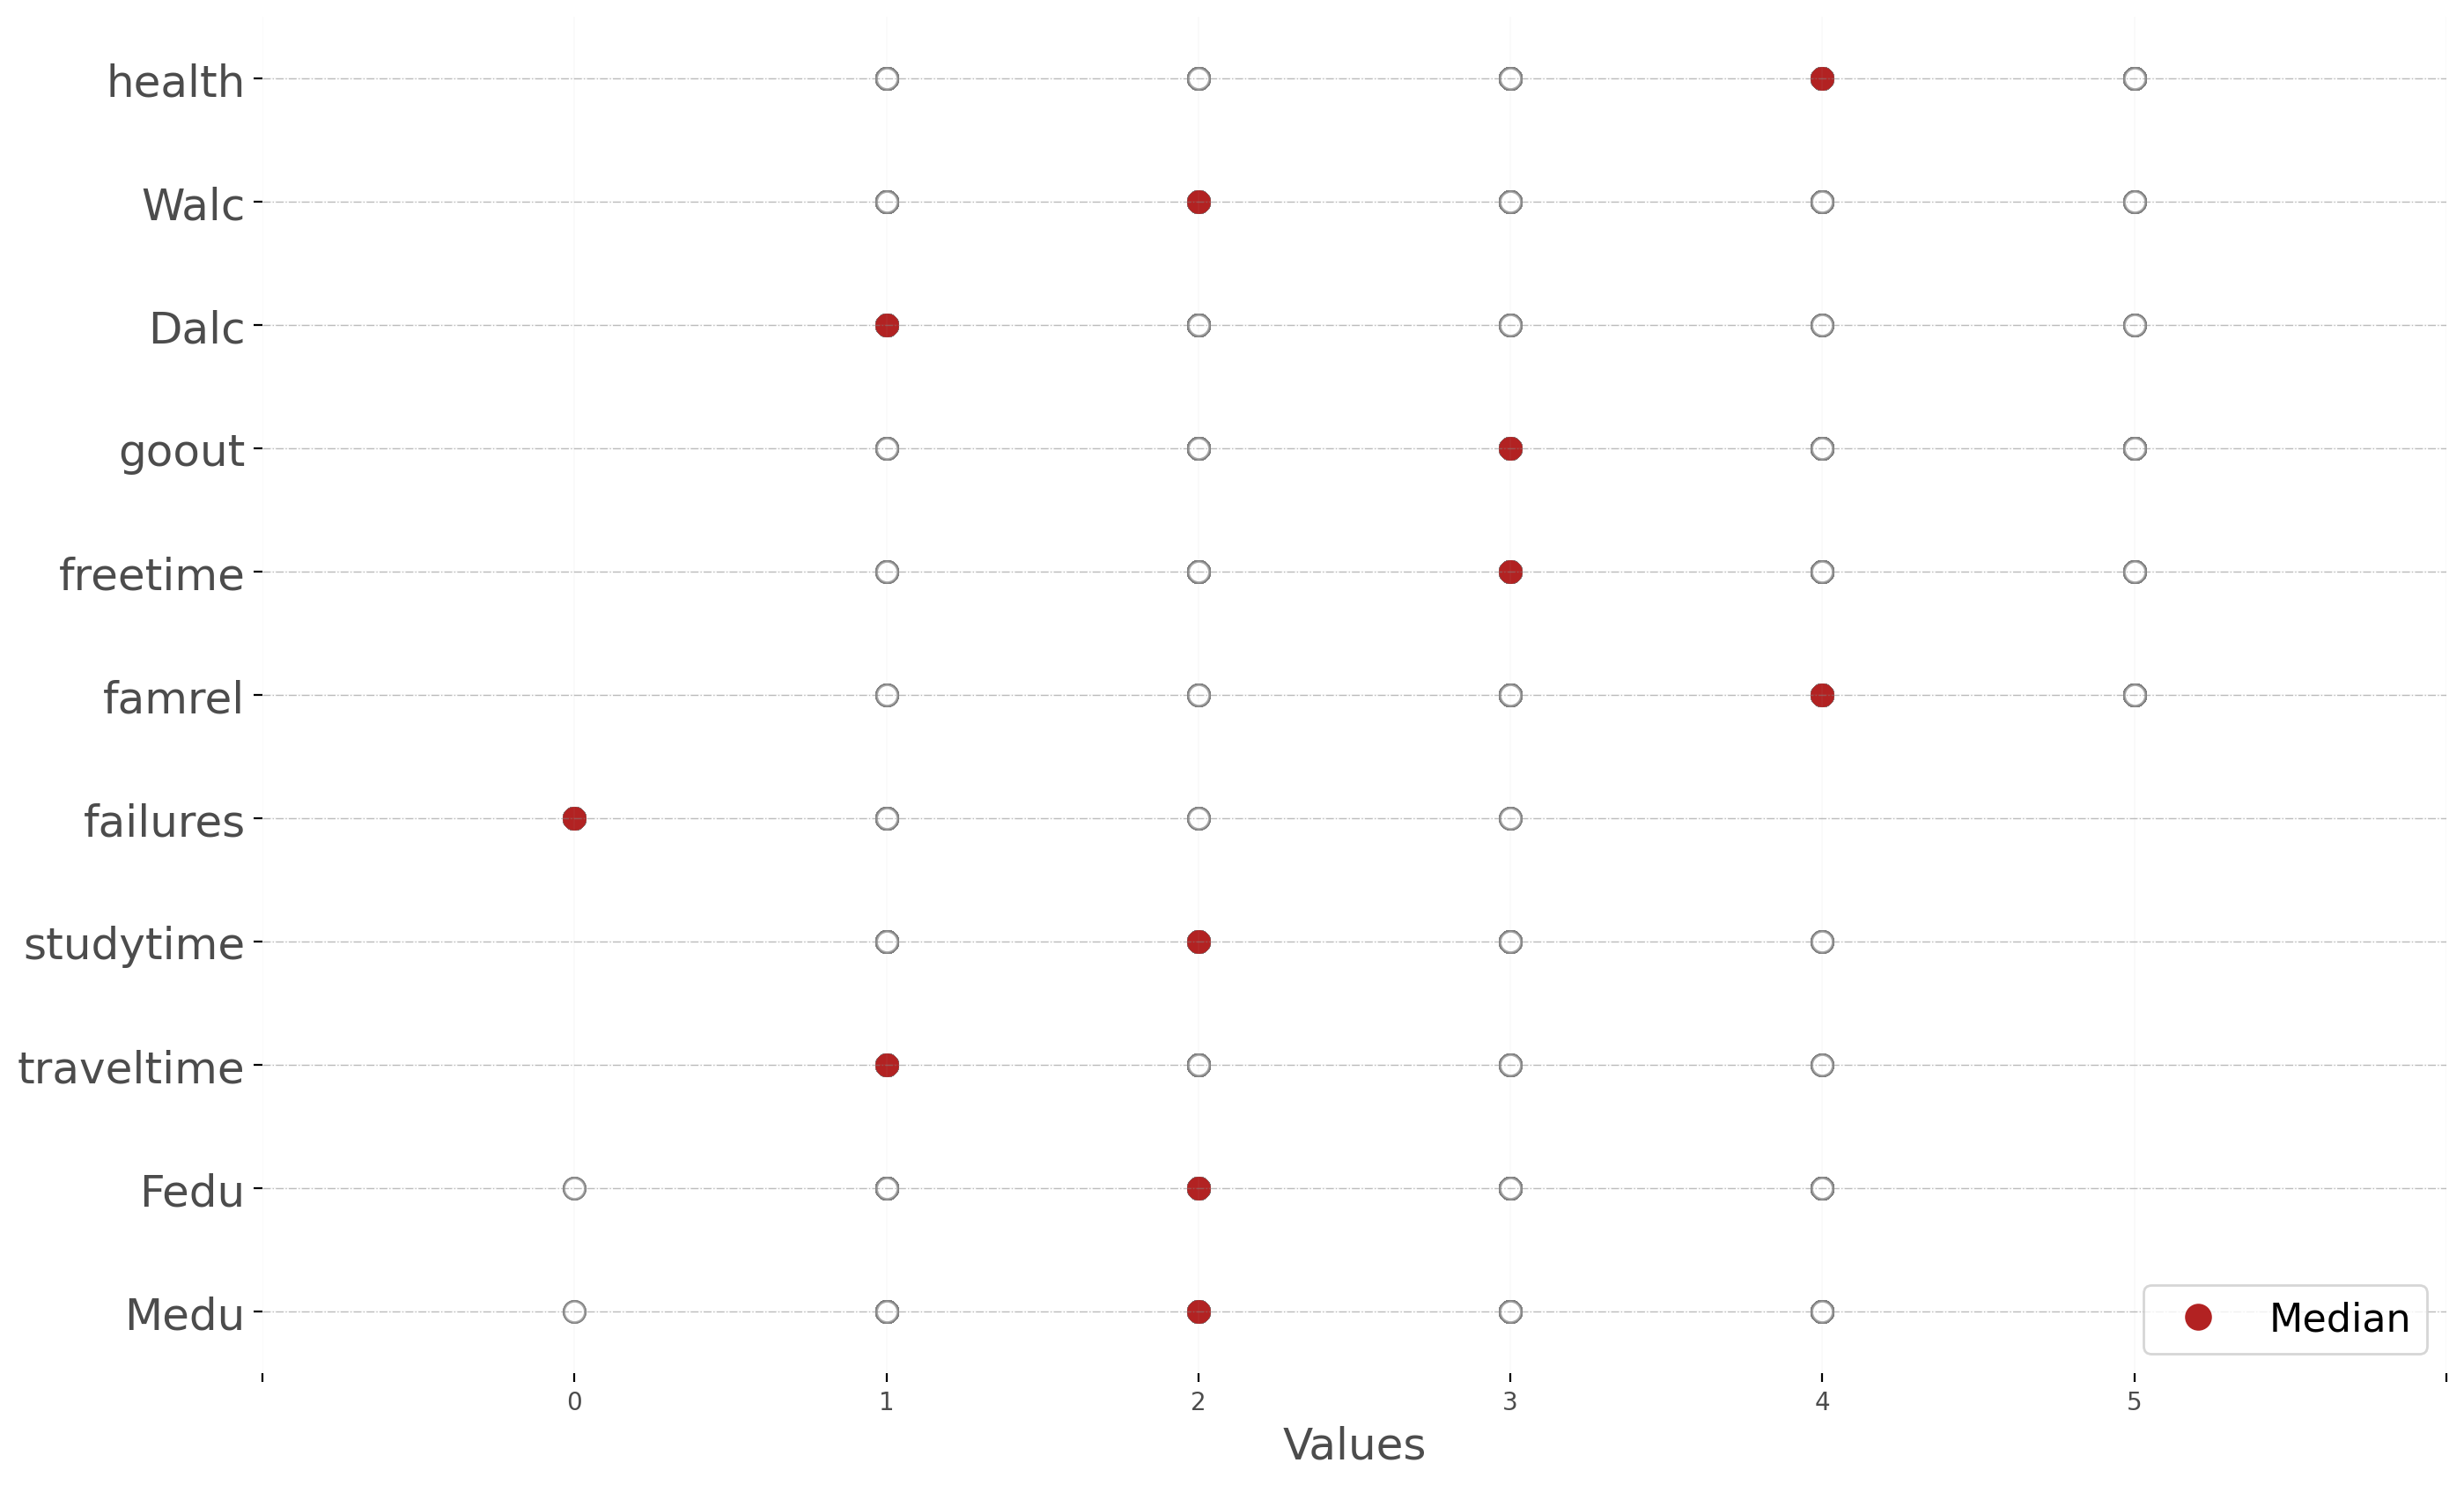

In [22]:
# Example usage
plot_distribution(data, int_columns_filtered1, '')
plt.show()

## Boxplot

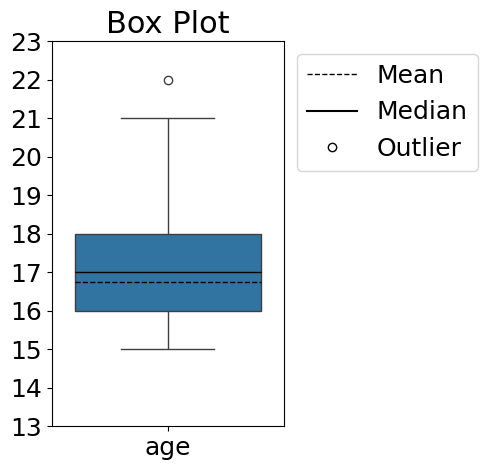

In [23]:
# Example usage
plot_boxplot(data, int_columns_filtered2, 'Box Plot')
plt.show()

## Shapiro

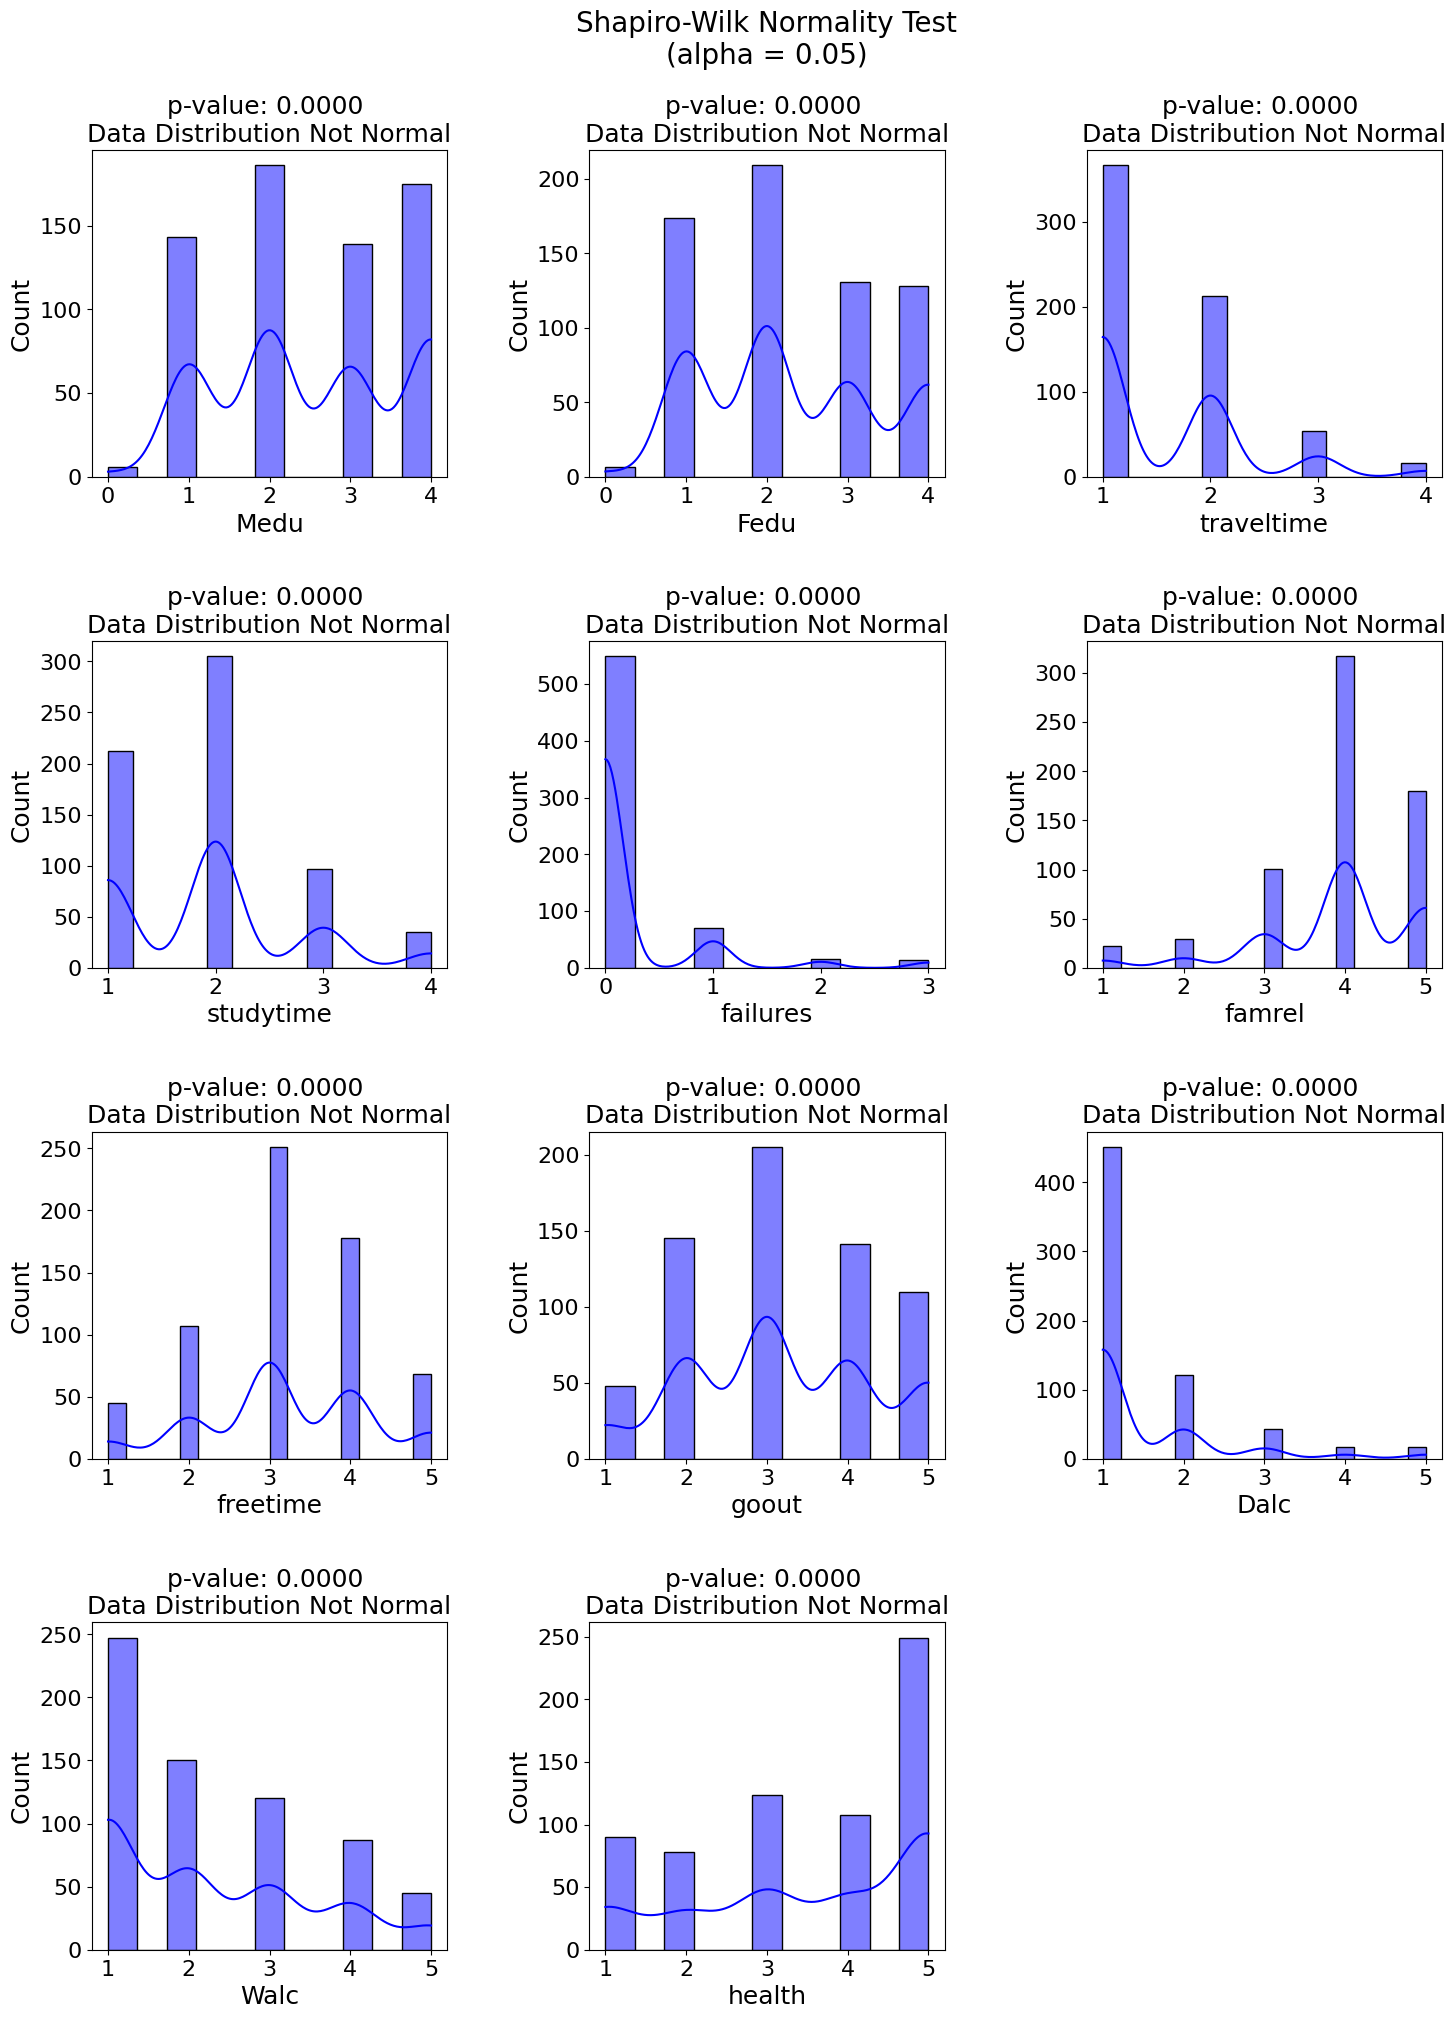

In [24]:
plot_normality_tests(data, int_columns_filtered1, "Shapiro-Wilk Normality Test")
plt.show()

## Correlation

In [25]:
correlation = data[int_columns_filtered1].copy()
correlation['school'] = data_transformed_sorted_y
int_columns_filtered1 = list(int_columns_filtered1)
int_columns_filtered1.append('school')

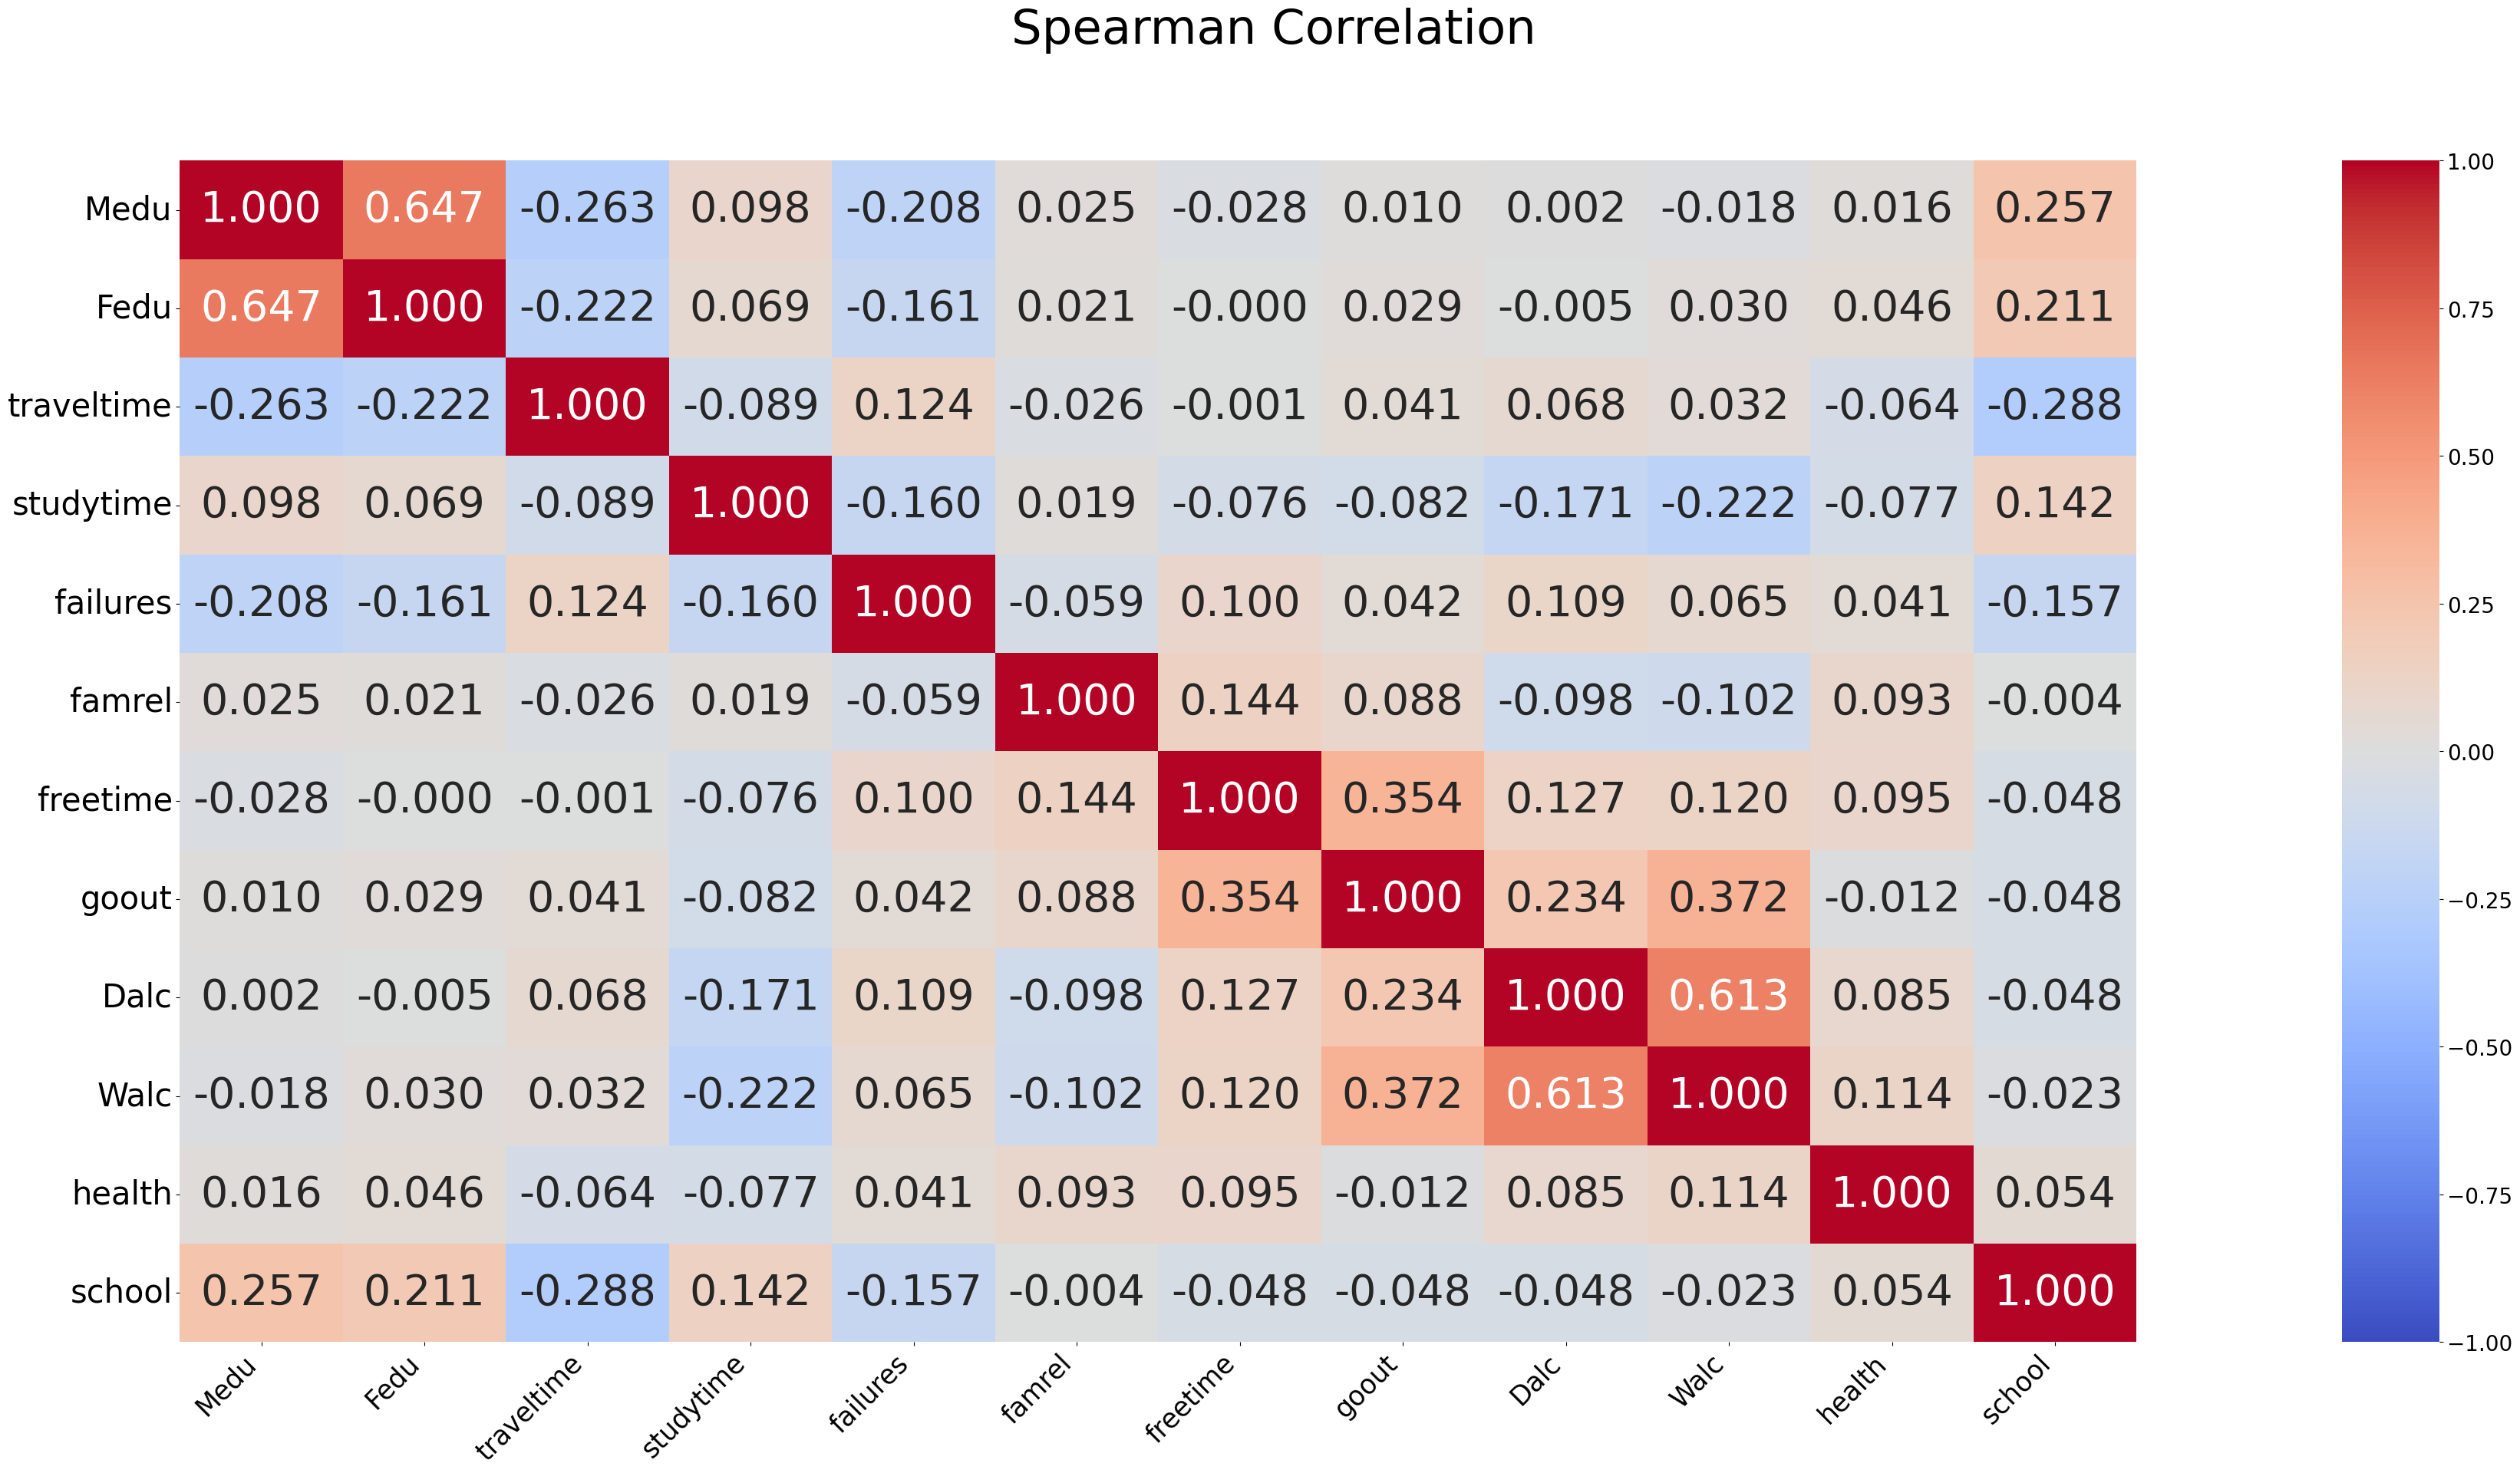

In [26]:
spearman_corr = heatmaps_spearman(correlation, int_columns_filtered1, 'Spearman Correlation');
plt.show()

/tmp/ipykernel_2075195/3831857375.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.values, y=correlations.index, palette='coolwarm')


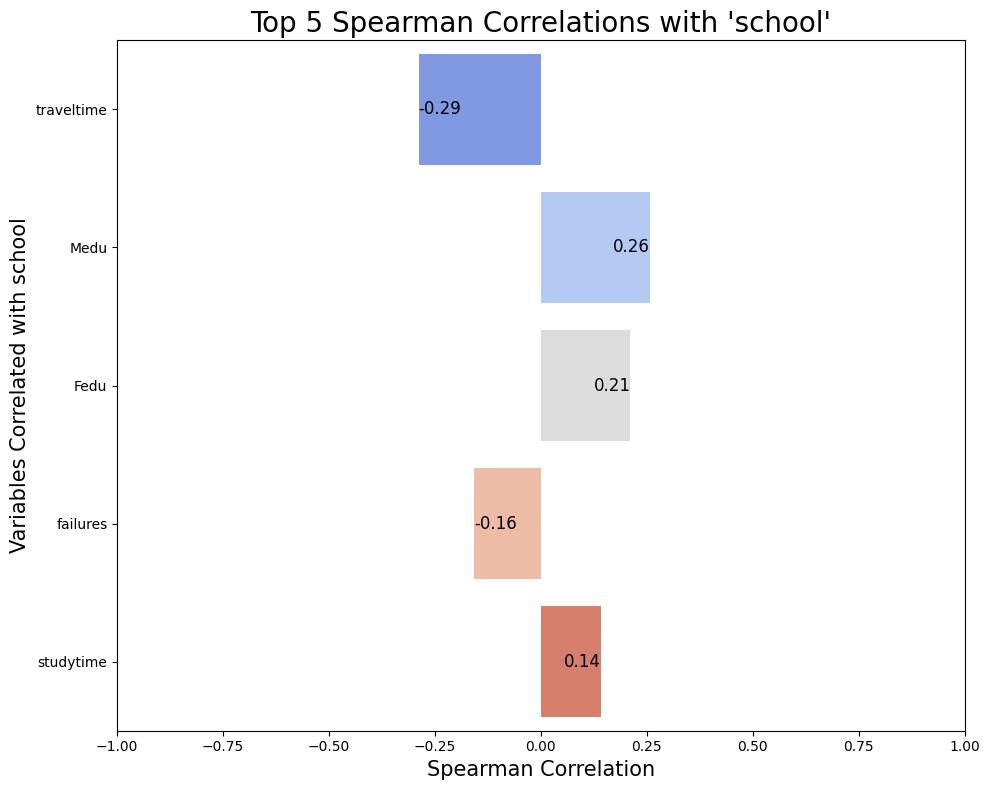

In [27]:
# Extract top 5 correlations with 'school'
top_n = 5
top_school_correlations = get_top_correlations_with_column(spearman_corr, 'school', top_n=top_n)

plot_correlations_with_column(
    correlations=top_school_correlations,
    target_column='school',
    title=f"Top {top_n} Spearman Correlations with 'school'"
)

# Machine learning

2024-11-11 11:58:43.518673: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-11-11 11:58:43.519292: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-11-11 11:58:43.531776: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-11-11 11:58:43.531934: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.2GHz coreCount: 30 deviceMemorySize: 5.78GiB deviceMemoryBandwidth: 244.97GiB/s
2024-11-11 11:58:43.531962: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-11-11 11:58:43.540307: I tensorflow/stream_executor/platform/defa

PATH: ./model/model.keras
ACCURACY: 0.83077
LOSS: 0.44967
F1 SCORE: 0.83077
Precision: 0.87059
Recall: 0.87059


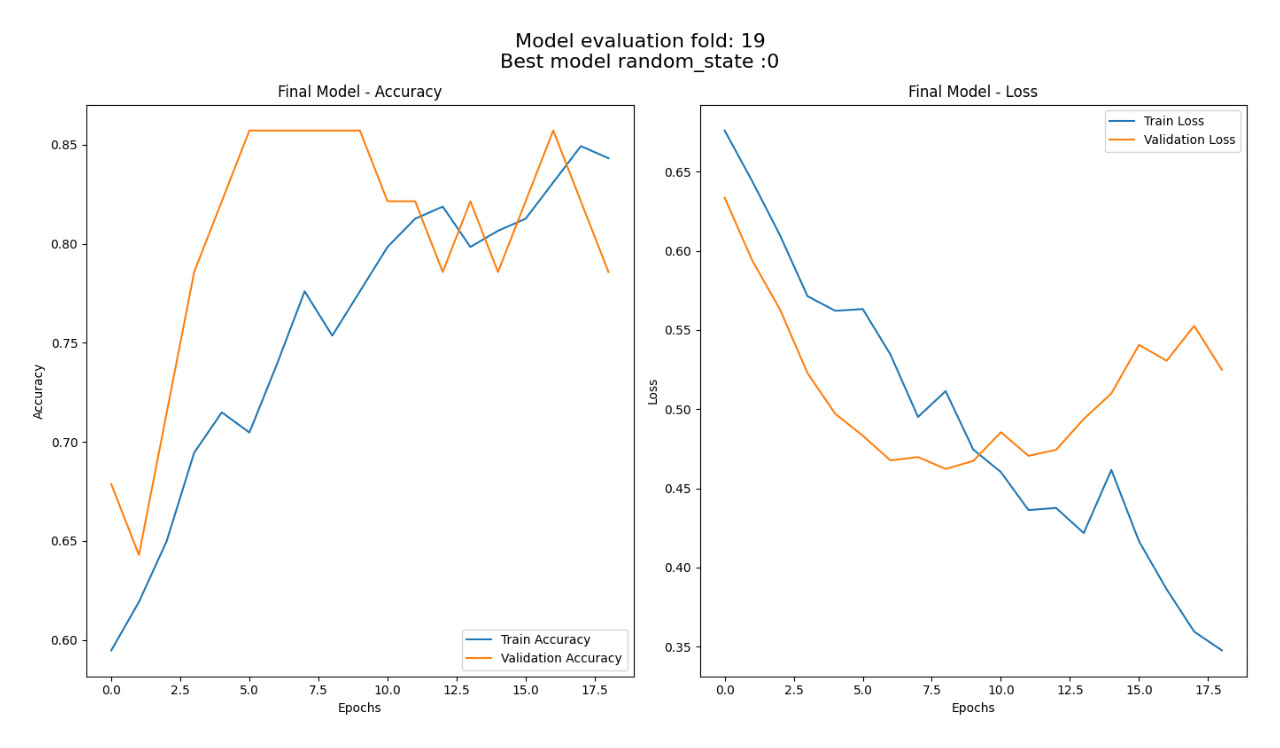

In [11]:
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Load your model
model_path = './model/model.keras'
model = load_model(model_path)

# Make predictions using the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
predictions = model.predict(X_test)  # Assuming you have a classification model
# Apply threshold of 0.5 for binary prediction
threshold = 0.5
y_pred = (predictions >= threshold).astype(float)

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='weighted')  # 'weighted' can be changed to 'macro', 'micro', etc. depending on your use case
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the results
print(f'PATH: {model_path}')
print(f'ACCURACY: {accuracy:.5f}')
print(f'LOSS: {loss:.5f}')
print(f'F1 SCORE: {f1:.5f}')
print(f'Precision: {precision:.5f}')
print(f'Recall: {recall:.5f}')

# Load and display image with higher DPI
image_path = model_path.replace('.keras', '.png')
img = plt.imread(image_path)
plt.figure(figsize=(8, 6), dpi=200)  # Adjust figsize and dpi as needed
plt.imshow(img)
plt.axis('off')
plt.show()


## ALL Data

PATH: ./model/model.keras
ACCURACY: 0.83077
LOSS: 0.44967
F1 SCORE: 0.83077
Precision: 0.83077
Recall: 0.83077
AUC-ROC Score: 0.85752


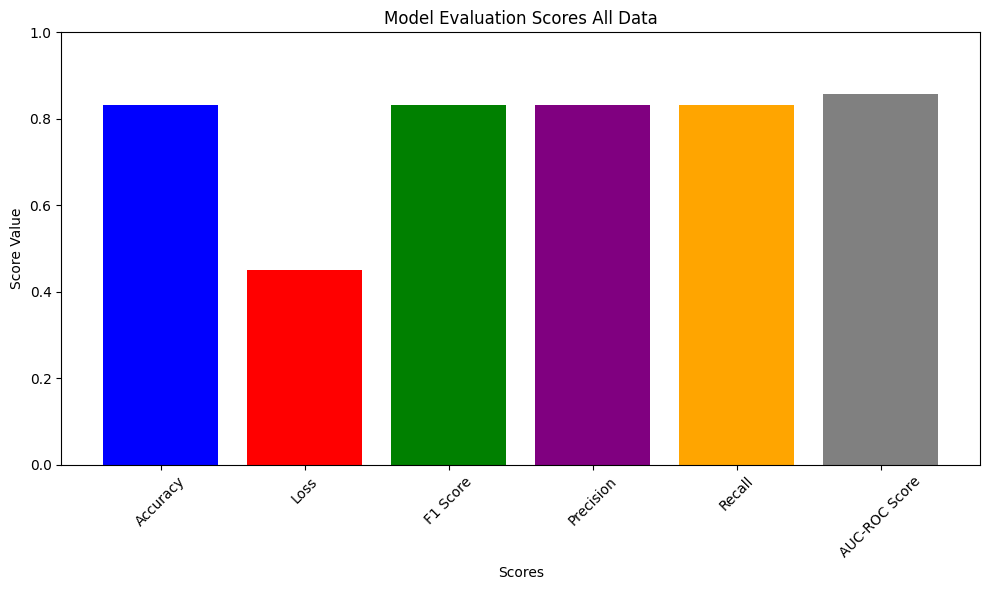

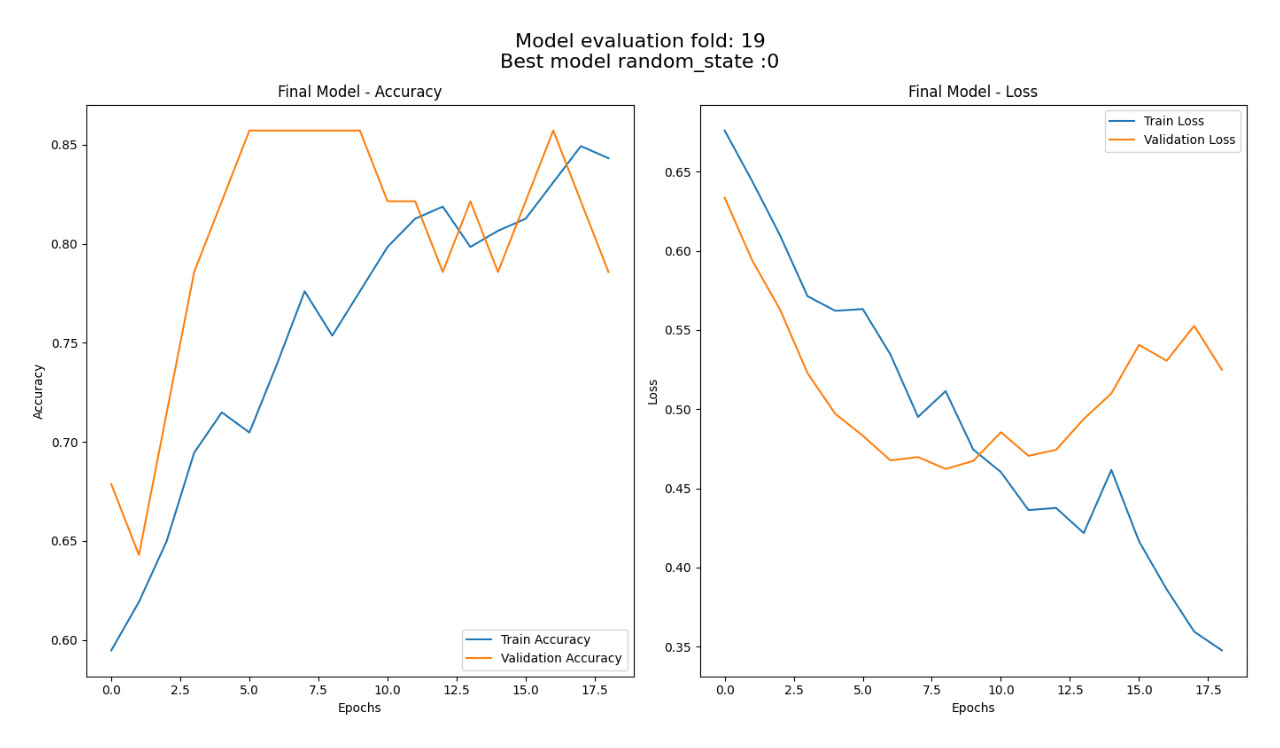

In [24]:
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_test and y_test are defined
# Load your model
model_path = './model/model.keras'
model = load_model(model_path)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

# Make predictions using the model
predictions = model.predict(X_test)

# Apply threshold for binary prediction
threshold = 0.5
y_pred = (predictions >= threshold).astype(float)

# Calculate F1 score, precision, recall
f1 = f1_score(y_test, y_pred, average='weighted')  # 'weighted' can be changed to 'macro', 'micro', etc.
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

# Calculate ROC AUC score
# For ROC AUC, use predicted probabilities for positive class
if predictions.shape[1] == 1:
    y_scores = predictions.ravel()  # For binary classification
else:
    y_scores = predictions[:, 1]  # For multi-class classification (assumes binary comparison)

auc_roc = roc_auc_score(y_test, y_scores)

# Print the results
print(f'PATH: {model_path}')
print(f'ACCURACY: {accuracy:.5f}')
print(f'LOSS: {loss:.5f}')
print(f'F1 SCORE: {f1:.5f}')
print(f'Precision: {precision:.5f}')
print(f'Recall: {recall:.5f}')
print(f'AUC-ROC Score: {auc_roc:.5f}')

# Visualization of scores
scores = [accuracy, loss, f1, precision, recall, auc_roc]
score_names = ['Accuracy', 'Loss', 'F1 Score', 'Precision', 'Recall', 'AUC-ROC Score']

plt.figure(figsize=(10, 6))
plt.bar(score_names, scores, color=['blue', 'red', 'green', 'purple', 'orange', 'gray'])
plt.title('Model Evaluation Scores All Data')
plt.xlabel('Scores')
plt.ylabel('Score Value')
plt.ylim(0.0, 1.0)  # Adjust y-axis limits if necessary
plt.xticks(rotation=45)
plt.tight_layout()

# Save or display the plot
plt.savefig('./model/evaluation_scores.png')  # Save the plot if needed
plt.show()

# Load and display image with higher DPI
image_path = model_path.replace('.keras', '.png')
img = plt.imread(image_path)
plt.figure(figsize=(8, 6), dpi=200)  # Adjust figsize and dpi as needed
plt.imshow(img)
plt.axis('off')
plt.show()


## Top 5 Corr

PATH: ./model/corr-model.keras
ACCURACY: 0.73846
LOSS: 0.59079
F1 SCORE: 0.71114
Precision: 0.73860
Recall: 0.73846
AUC-ROC Score: 0.74824


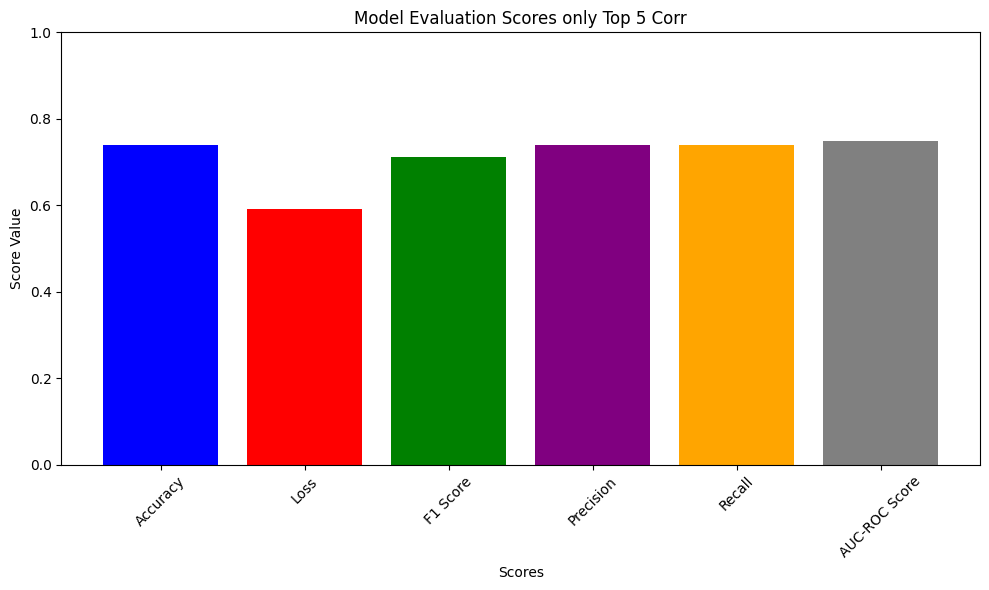

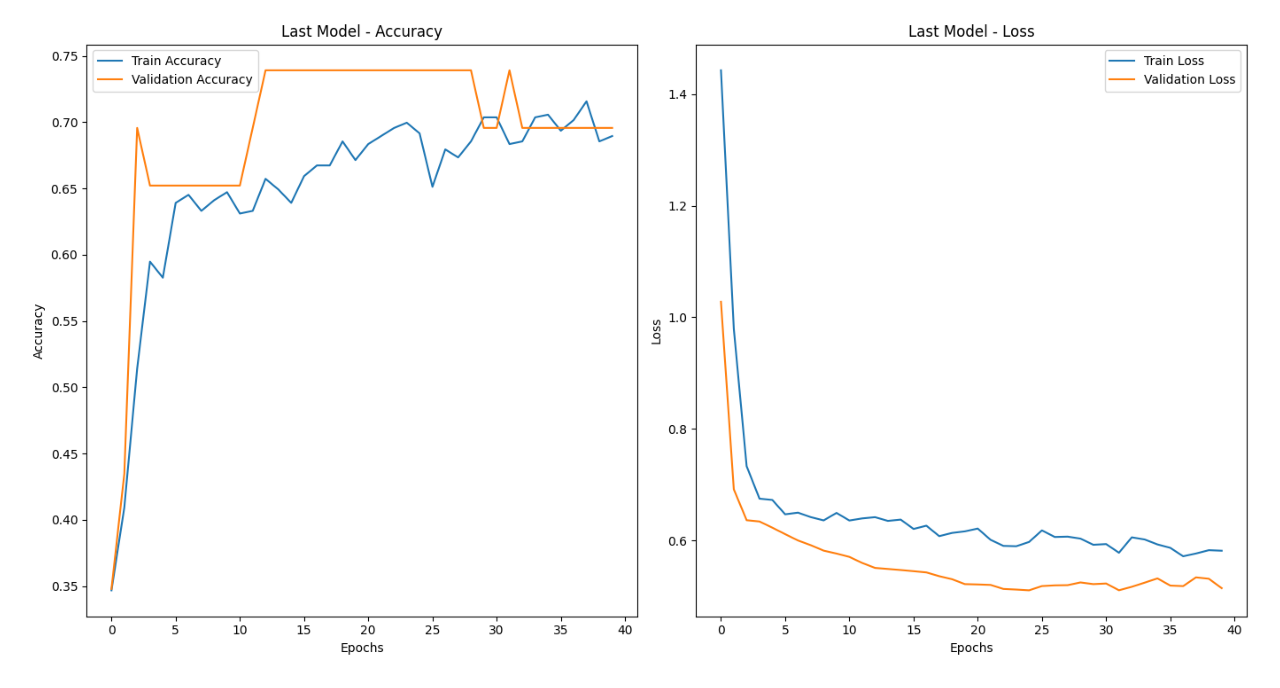

In [25]:
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_test and y_test are defined
# Load your model
model_path = './model/corr-model.keras'
model = load_model(model_path)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_corr_scaled, y_test, verbose=0)

# Make predictions using the model
predictions = model.predict(X_test_corr_scaled)

# Apply threshold for binary prediction
threshold = 0.5
y_pred = (predictions >= threshold).astype(float)

# Calculate F1 score, precision, recall
f1 = f1_score(y_test, y_pred, average='weighted')  # 'weighted' can be changed to 'macro', 'micro', etc.
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

# Calculate ROC AUC score
# For ROC AUC, use predicted probabilities for positive class
if predictions.shape[1] == 1:
    y_scores = predictions.ravel()  # For binary classification
else:
    y_scores = predictions[:, 1]  # For multi-class classification (assumes binary comparison)

auc_roc = roc_auc_score(y_test, y_scores)

# Print the results
print(f'PATH: {model_path}')
print(f'ACCURACY: {accuracy:.5f}')
print(f'LOSS: {loss:.5f}')
print(f'F1 SCORE: {f1:.5f}')
print(f'Precision: {precision:.5f}')
print(f'Recall: {recall:.5f}')
print(f'AUC-ROC Score: {auc_roc:.5f}')

# Visualization of scores
scores = [accuracy, loss, f1, precision, recall, auc_roc]
score_names = ['Accuracy', 'Loss', 'F1 Score', 'Precision', 'Recall', 'AUC-ROC Score']

plt.figure(figsize=(10, 6))
plt.bar(score_names, scores, color=['blue', 'red', 'green', 'purple', 'orange', 'gray'])
plt.title('Model Evaluation Scores only Top 5 Corr')
plt.xlabel('Scores')
plt.ylabel('Score Value')
plt.ylim(0.0, 1.0)  # Adjust y-axis limits if necessary
plt.xticks(rotation=45)
plt.tight_layout()

# Save or display the plot
plt.savefig('./model/corr-evaluation_scores.png')  # Save the plot if needed
plt.show()

# Load and display image with higher DPI
image_path = model_path.replace('.keras', '.png')
img = plt.imread(image_path)
plt.figure(figsize=(8, 6), dpi=200)  # Adjust figsize and dpi as needed
plt.imshow(img)
plt.axis('off')
plt.show()


## Without Top 5 Corr

PATH: ./model/uncorr-model.keras
ACCURACY: 0.79231
LOSS: 0.45721
F1 SCORE: 0.78416
Precision: 0.78914
Recall: 0.79231
AUC-ROC Score: 0.86327


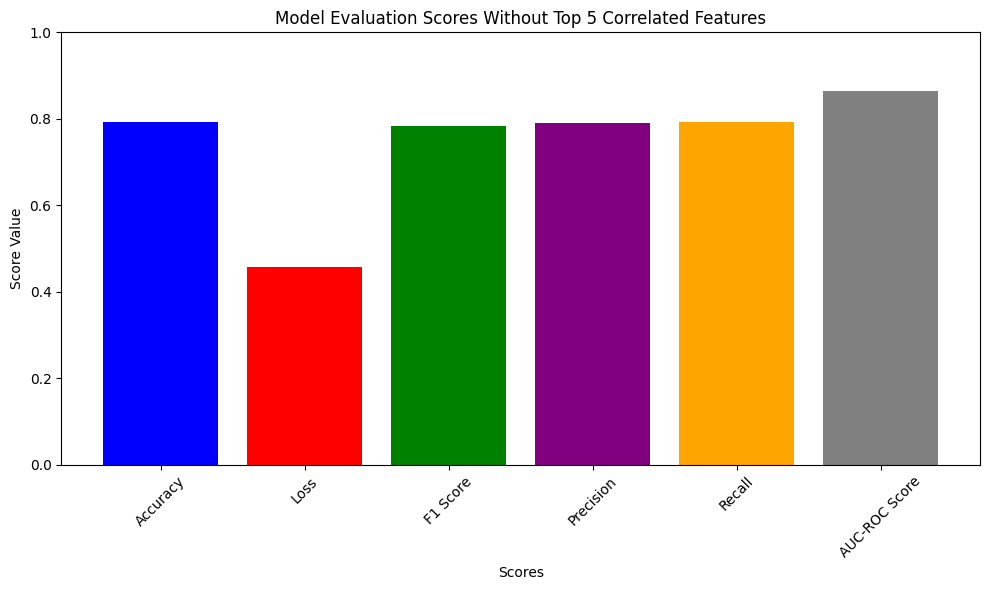

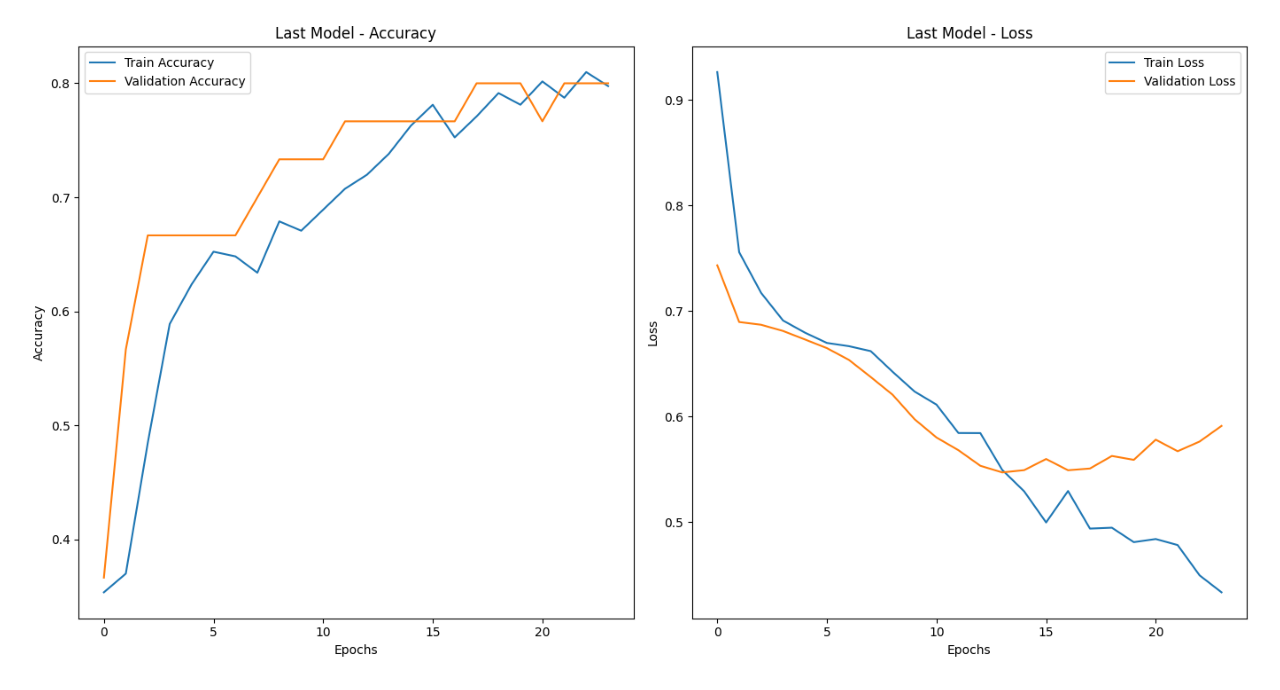

In [26]:
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_test and y_test are defined
# Load your model
model_path = './model/uncorr-model.keras'
model = load_model(model_path)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_uncorr_scaled, y_test, verbose=0)

# Make predictions using the model
predictions = model.predict(X_test_uncorr_scaled)

# Apply threshold for binary prediction
threshold = 0.5
y_pred = (predictions >= threshold).astype(float)

# Calculate F1 score, precision, recall
f1 = f1_score(y_test, y_pred, average='weighted')  # 'weighted' can be changed to 'macro', 'micro', etc.
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

# Calculate ROC AUC score
# For ROC AUC, use predicted probabilities for positive class
if predictions.shape[1] == 1:
    y_scores = predictions.ravel()  # For binary classification
else:
    y_scores = predictions[:, 1]  # For multi-class classification (assumes binary comparison)

auc_roc = roc_auc_score(y_test, y_scores)

# Print the results
print(f'PATH: {model_path}')
print(f'ACCURACY: {accuracy:.5f}')
print(f'LOSS: {loss:.5f}')
print(f'F1 SCORE: {f1:.5f}')
print(f'Precision: {precision:.5f}')
print(f'Recall: {recall:.5f}')
print(f'AUC-ROC Score: {auc_roc:.5f}')

# Visualization of scores
scores = [accuracy, loss, f1, precision, recall, auc_roc]
score_names = ['Accuracy', 'Loss', 'F1 Score', 'Precision', 'Recall', 'AUC-ROC Score']

plt.figure(figsize=(10, 6))
plt.bar(score_names, scores, color=['blue', 'red', 'green', 'purple', 'orange', 'gray'])
plt.title('Model Evaluation Scores Without Top 5 Correlated Features')
plt.xlabel('Scores')
plt.ylabel('Score Value')
plt.ylim(0.0, 1.0)  # Adjust y-axis limits if necessary
plt.xticks(rotation=45)
plt.tight_layout()

# Save or display the plot
plt.savefig('./model/uncorr-evaluation_scores.png')  # Save the plot if needed
plt.show()

# Load and display image with higher DPI
image_path = model_path.replace('.keras', '.png')
img = plt.imread(image_path)
plt.figure(figsize=(8, 6), dpi=200)  # Adjust figsize and dpi as needed
plt.imshow(img)
plt.axis('off')
plt.show()


## Without NonTop 5 Corr

PATH: ./model/noncorr-model.keras
ACCURACY: 0.81538
LOSS: 0.44758
F1 SCORE: 0.80897
Precision: 0.81377
Recall: 0.81538
AUC-ROC Score: 0.86013


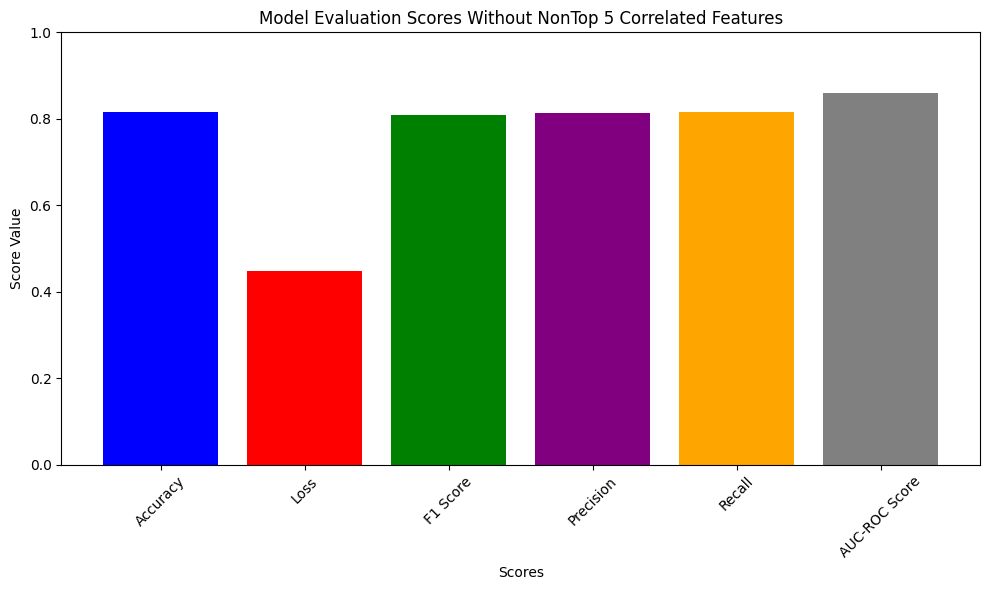

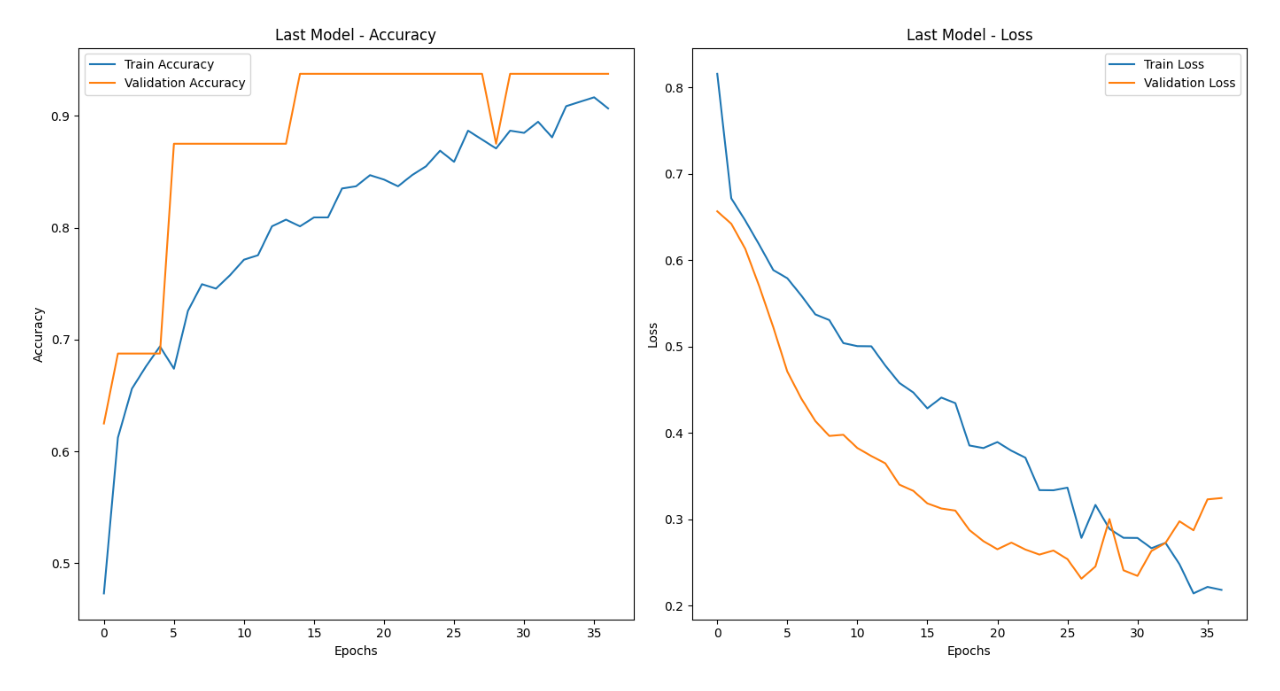

In [27]:
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_test and y_test are defined
# Load your model
model_path = './model/noncorr-model.keras'
model = load_model(model_path)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_noncorr_scaled, y_test, verbose=0)

# Make predictions using the model
predictions = model.predict(X_test_noncorr_scaled)

# Apply threshold for binary prediction
threshold = 0.5
y_pred = (predictions >= threshold).astype(float)

# Calculate F1 score, precision, recall
f1 = f1_score(y_test, y_pred, average='weighted')  # 'weighted' can be changed to 'macro', 'micro', etc.
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

# Calculate ROC AUC score
# For ROC AUC, use predicted probabilities for positive class
if predictions.shape[1] == 1:
    y_scores = predictions.ravel()  # For binary classification
else:
    y_scores = predictions[:, 1]  # For multi-class classification (assumes binary comparison)

auc_roc = roc_auc_score(y_test, y_scores)

# Print the results
print(f'PATH: {model_path}')
print(f'ACCURACY: {accuracy:.5f}')
print(f'LOSS: {loss:.5f}')
print(f'F1 SCORE: {f1:.5f}')
print(f'Precision: {precision:.5f}')
print(f'Recall: {recall:.5f}')
print(f'AUC-ROC Score: {auc_roc:.5f}')

# Visualization of scores
scores = [accuracy, loss, f1, precision, recall, auc_roc]
score_names = ['Accuracy', 'Loss', 'F1 Score', 'Precision', 'Recall', 'AUC-ROC Score']

plt.figure(figsize=(10, 6))
plt.bar(score_names, scores, color=['blue', 'red', 'green', 'purple', 'orange', 'gray'])
plt.title('Model Evaluation Scores Without NonTop 5 Correlated Features')
plt.xlabel('Scores')
plt.ylabel('Score Value')
plt.ylim(0.0, 1.0)  # Adjust y-axis limits if necessary
plt.xticks(rotation=45)
plt.tight_layout()

# Save or display the plot
plt.savefig('./model/noncorr-evaluation_scores.png')  # Save the plot if needed
plt.show()

# Load and display image with higher DPI
image_path = model_path.replace('.keras', '.png')
img = plt.imread(image_path)
plt.figure(figsize=(8, 6), dpi=200)  # Adjust figsize and dpi as needed
plt.imshow(img)
plt.axis('off')
plt.show()


In [ ]:
# Assuming predictions and y_test are loaded correctly
predictions = model.predict(X_test)
y_test = np.array(y_test)  # Convert y_test to numpy array if it's a pandas Series

# Apply threshold of 0.5 for binary prediction
threshold = 0.5
binary_predictions = (predictions >= threshold).astype(float)

# Example of printing the predictions
for i in range(len(binary_predictions)):
    print(f"Example {i+1}: Predicted value: {binary_predictions[i][0]}, True value: {y_test[i]}")



In [ ]:
# Assuming predictions and y_test are loaded correctly and processed as described
predictions = model.predict(X_test)
y_test = np.array(y_test)  # Convert y_test to numpy array if it's a pandas Series

# Apply threshold of 0.5 for binary prediction
threshold = 0.5
binary_predictions = (predictions >= threshold).astype(float)

# Find indices where predictions do not match y_test
wrong_indices = np.where(binary_predictions != y_test)[0]

# Print examples where predictions are incorrect
for idx in wrong_indices:
    print(f"Example {idx + 1}: Predicted value: {binary_predictions[idx][0]}, True value: {y_test[idx]}")

In [ ]:
data_MS = data[data["school"] == 'MS']
data_MSX = data_MS.drop(columns='school')
data_MSY = data_MS['school']
pdata_MSY = pd.DataFrame(data_MSY, columns=['school'])

In [ ]:
data_MSX_t = transform_and_sort(data_MSX, pipeline, desired_prefix_order)
data_MSX_s = scaler.transform(data_MSX_t)
data_MSY_t = transform_and_sort_y(pdata_MSY, pipeline_y, desired_prefix_order_y)

In [ ]:
# Assuming predictions and y_test are loaded correctly and processed as described
predictions = model.predict(data_MSX_s)
y_test = np.array(data_MSY_t)  # Convert y_test to numpy array if it's a pandas Series

# Apply threshold of 0.5 for binary prediction
threshold = 0.5
binary_predictions = (predictions >= threshold).astype(float)

# Find indices where predictions do not match y_test
wrong_indices = np.where(binary_predictions != y_test)[0]

# Print examples where predictions are incorrect
for idx in wrong_indices:
    print(f"Example {idx + 1}: Predicted value: {binary_predictions[idx][0]}, True value: {y_test[idx]}")
print(f'Wrong Predicted : {len(wrong_indices)}')

In [ ]:
data_GP = data[data["school"] == 'GP']
data_GPX = data_GP.drop(columns='school')
data_GPY = data_GP['school']
pdata_GPY = pd.DataFrame(data_GPY, columns=['school'])

In [ ]:
data_GPX_t = transform_and_sort(data_GPX, pipeline, desired_prefix_order)
data_GPX_s = scaler.transform(data_GPX_t)
data_GPY_t = transform_and_sort_y(pdata_GPY, pipeline_y, desired_prefix_order_y)

In [ ]:
# Assuming predictions and y_test are loaded correctly and processed as described
predictions = model.predict(data_GPX_s)
y_test = np.array(data_GPY_t)  # Convert y_test to numpy array if it's a pandas Series

# Apply threshold of 0.5 for binary prediction
threshold = 0.5
binary_predictions = (predictions >= threshold).astype(float)

# Find indices where predictions do not match y_test
wrong_indices = np.where(binary_predictions != y_test)[0]

# Print examples where predictions are incorrect
for idx in wrong_indices:
    print(f"Example {idx + 1}: Predicted value: {binary_predictions[idx][0]}, True value: {y_test[idx]}")
print(f'Wrong Predicted : {len(wrong_indices)}')